In [49]:
import random
import numpy as np
import time
import matplotlib.pyplot as plt
import math

# Configuración

In [16]:
def configure(
    sample_size: int = 10,
    genes: int = 4,
    mutation_rate: float = 0.1,
    max_episodes: int = 100,
    population_size: int = 20,
    reproduction_rate: int = 2,
    novelty_rate: float = 0.01,
    connectivity_rate: float = 0.5,
) -> None:
    """
    Configura el ambiente en el que se ejecuta el algoritmo genético.
    
    SAMPLE_SIZE: La cantidad de regiones en el mapa, que pueden ser coloreadas.
    GENES: La cantidad de colores que se pueden utilizar.
    MUTATION_RATE: La probabilidad de que un color aleatorio de una muestra mute en un episodio.
    MAX_EPISODES: La cantidad total de episodios
    POPULATION_SIZE: La cantidad de muestras que sobreviven cada episodio.
    REPRODUCTION_RATE: La cantidad de hijos que genera cada muestra en cada episodio.
    NOVELTY_RATE: La variación aleatoria en el costo de cada muestra, para preservar cierta novedad en los episdios.
    CONNECTIVITY_RATE: La probabilidad de que dos regiones del mapa aleatorias estén conectadas entre si.
    """
    globals()['SAMPLE_SIZE'] = sample_size
    globals()['GENES'] = genes
    globals()['MUTATION_RATE'] = mutation_rate
    globals()['MAX_EPISODES'] = max_episodes
    globals()['POPULATION_SIZE'] = population_size
    globals()['REPRODUCTION_RATE'] = reproduction_rate
    globals()['NOVELTY_RATE'] = novelty_rate
    globals()['CONNECTIVITY_RATE'] = connectivity_rate

# Funciones

In [3]:
class WinnerFoundException(Exception):
    """
    Esta excepción se utiliza para señalar que se ha encontrado un "ganador" de forma temprana.
    """
    def __init__(self, sample: np.array):
        self.winner = sample

In [4]:
def generate_adjacency_matrix() -> np.array:
    """
    Esta función crea una matriz de adyacencia simétrica para representar un mapa en forma de grafo. 

    La probabilidad de que exista una conexión entre dos nodos es definida por la tasa de conectividad
    global CONNECTIVITY_RATE.
    
    Los valores de la matriz son 0 o 1, donde 1 indica una conexión entre dos nodos.
    """
    assert CONNECTIVITY_RATE > 0
    assert CONNECTIVITY_RATE < 1
    assert SAMPLE_SIZE > 0
    matrix: np.array = np.random.choice(
        [0, 1],
        size=(SAMPLE_SIZE, SAMPLE_SIZE),
        p=[1 - CONNECTIVITY_RATE, CONNECTIVITY_RATE]
    )
    np.fill_diagonal(matrix, 0)
    return (matrix + matrix.T) // 2

In [5]:
def calculate_color_matrix(adjacency: np.array, sample: np.array) -> np.array:
    """
    Esta función crea una matriz que representa la distribución de colores en un grafo, 
    utilizando la matriz de adyacencia del grafo y una muestra que indica el color de 
    cada nodo.
    """
    assert SAMPLE_SIZE > 0
    return adjacency * np.tile(sample, (SAMPLE_SIZE, 1))

In [6]:
def calculate_cost(adjacency: np.array, sample: np.array) -> float:
    """
    Esta función determina el costo de una solución particular representada por 'sample', 
    basándose en una matriz de adyacencia 'adjacency'.
    
    El costo es la suma de las incompatibilidades entre los nodos adyacentes del grafo,
    donde una incompatibilidad se da si dos nodos adyacentes tienen el mismo color.
    
    Un costo más bajo indica una mejor solución. Además, se añade un pequeño valor aleatorio
    (definido por NOVELTY_RATE) al costo para introducir diversidad en las soluciones.
    """
    assert NOVELTY_RATE >= 0
    assert SAMPLE_SIZE > 0
    cost: float = sum([
        1 if element == gene else 0
        for row, gene in enumerate(sample)
        for element in calculate_color_matrix(adjacency, sample)[row]
    ])
    if cost == 0.0:
        raise WinnerFoundException(sample=sample)
    return cost + random.uniform(0, NOVELTY_RATE)

In [7]:
def initialize_population() -> tuple:
    """
    Esta función crea una población inicial.
    
    Cada individuo en la población es un arreglo de números enteros, donde cada número representa un gen.
    Los valores de los genes están en el rango [1, GENES]. La población se compone de POPULATION_SIZE individuos,
    y cada individuo tiene SAMPLE_SIZE genes.
    """
    return (
        np.random.randint(1, GENES + 1, size=SAMPLE_SIZE)
        for _ in range(POPULATION_SIZE)
    )

In [8]:
def mutate(sample: np.array) -> np.array:
    """
    Esta función realiza mutaciones en un individuo (representado por 'sample'), 
    cambiando aleatoriamente el valor de algunos de sus genes. El número de mutaciones 
    se determina a partir de la tasa de mutación MUTATION_RATE. Cada gen mutado recibe 
    un nuevo valor aleatorio dentro del rango válido de genes.
    """
    assert MUTATION_RATE > 0
    assert MUTATION_RATE < 1
    assert GENES > 0
    mutations: int = max(1, int(SAMPLE_SIZE * MUTATION_RATE))
    indices: np.array = np.random.choice(len(sample), mutations, replace=False)
    for index in indices:
        sample[index] = np.random.randint(1, GENES + 1)
    return sample

In [9]:
def reproduce(population: tuple) -> tuple:
    """
    Esta función simula el proceso de reproducción.
    
    Cada individuo en la población original se reproduce una cantidad de veces definida 
    por REPRODUCTION_RATE, generando nuevos individuos. Cada nuevo individuo es 
    una copia mutada del original, aplicándose la función 'mutate' para introducir 
    variaciones genéticas.
    """
    assert REPRODUCTION_RATE > 1
    return (mutate(sample) for sample in population for _ in range(REPRODUCTION_RATE))

In [10]:
def select(population: tuple) -> tuple:
    """
    Esta función evalúa la aptitud (fitness) de cada individuo en la población usando la función 
    'calculate_cost' y selecciona un subconjunto de individuos con la mejor aptitud.
    
    Los individuos con menor costo (mayor aptitud) son seleccionados para formar la próxima generación.
    """
    assert POPULATION_SIZE > 0
    fitness: dict = {calculate_cost(adjacency, sample): sample for sample in population}
    return (sample for _, sample in sorted(fitness.items())[:POPULATION_SIZE])

In [11]:
def optimize(adjacency: np.array) -> tuple:
    """
    Esta función implementa un algoritmo genético para encontrar una solución óptima
    al problema de colorear un mapa, modelado a través de la matriz de adjacencia.

    El algoritmo itera a través de un número de episodios (EPISODES), en cada uno de 
    los cuales la población se reproduce y se seleccionan los individuos más aptos. 

    Si se encuentra un 'ganador' (una solución sin costo), el algoritmo termina 
    prematuramente. 
    """
    start_time: float = time.time()
    assert MAX_EPISODES > 0
    population: tuple = initialize_population()
    for episode in range(1, MAX_EPISODES + 1):
        print("Episode: ", episode)
        children: tuple = reproduce(population)
        try:
            population: tuple = select(children)
        except WinnerFoundException as exception:
            return episode, 0, exception.winner, time.time() - start_time
    winner: np.array = list(population)[0]
    return episode, calculate_cost(adjacency, winner), winner, time.time() - start_time

In [17]:
def print_results(adjacency: np.array, episodes: int, cost: float, winner: np.array, duration: float) -> None:
    """
    Esta función imprime los resultados de una prueba en pantalla.
    """
    print('------------------------------------------------------')
    print('Episodes:', episodes)
    print('Time:', duration)
    print('Cost::', cost)
    print('Colors:', winner)
    print('Results:')
    print(calculate_color_matrix(adjacency, winner))
    print('------------------------------------------------------')

# Pruebas

## Prueba Simple

In [43]:
configure()
adjacency: np.array = generate_adjacency_matrix()
episodes, cost, winner, duration = optimize(adjacency)
print_results(episodes=episodes, cost=cost, winner=winner, adjacency=adjacency, duration=duration)

Episode:  1
------------------------------------------------------
Episodes: 1
Time: 0.0028138160705566406
Cost:: 0
Colors: [3 1 1 2 2 2 3 1 1 4]
Results:
[[0 1 1 2 0 0 0 0 0 4]
 [3 0 0 0 0 0 0 0 0 4]
 [3 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 3 0 1 0]
 [0 0 0 0 0 0 0 0 0 4]
 [0 0 0 0 0 0 3 1 0 0]
 [0 0 0 2 0 2 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0]
 [3 1 0 0 2 0 0 0 0 0]]
------------------------------------------------------


## Variación en el tamaño de la muestra

In [60]:
times: list = []
costs: list = []
values: list = []
for run in range(15):
    value: int = 10 + 5 * run
    values.append(value)
    configure(sample_size=value)
    adjacency: np.array = generate_adjacency_matrix()
    episodes, cost, winner, duration = optimize(adjacency)
    print_results(episodes=episodes, cost=cost, winner=winner, adjacency=adjacency, duration=duration)
    costs.append(cost)
    times.append(duration)

Episode:  1
------------------------------------------------------
Episodes: 1
Time: 0.005103111267089844
Cost:: 0
Colors: [2 1 1 3 2 2 2 1 3 4]
Results:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 3 0]
 [0 0 0 0 2 2 2 1 0 0]
 [0 0 0 3 0 0 0 0 0 4]
 [0 0 1 3 0 0 0 1 0 4]
 [0 0 0 3 0 0 0 0 0 0]
 [0 0 0 3 0 2 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 4]
 [0 0 0 0 2 2 0 0 3 0]]
------------------------------------------------------
Episode:  1
Episode:  2
Episode:  3
Episode:  4
Episode:  5
Episode:  6
Episode:  7
Episode:  8
Episode:  9
Episode:  10
Episode:  11
Episode:  12
Episode:  13
Episode:  14
Episode:  15
Episode:  16
Episode:  17
Episode:  18
Episode:  19
Episode:  20
Episode:  21
Episode:  22
Episode:  23
Episode:  24
Episode:  25
Episode:  26
Episode:  27
Episode:  28
Episode:  29
Episode:  30
Episode:  31
Episode:  32
Episode:  33
Episode:  34
Episode:  35
Episode:  36
Episode:  37
Episode:  38
Episode:  39
Episode:  40
Episode:  41
Episode:  42
Episode:  43
Episode:  

KeyboardInterrupt: 

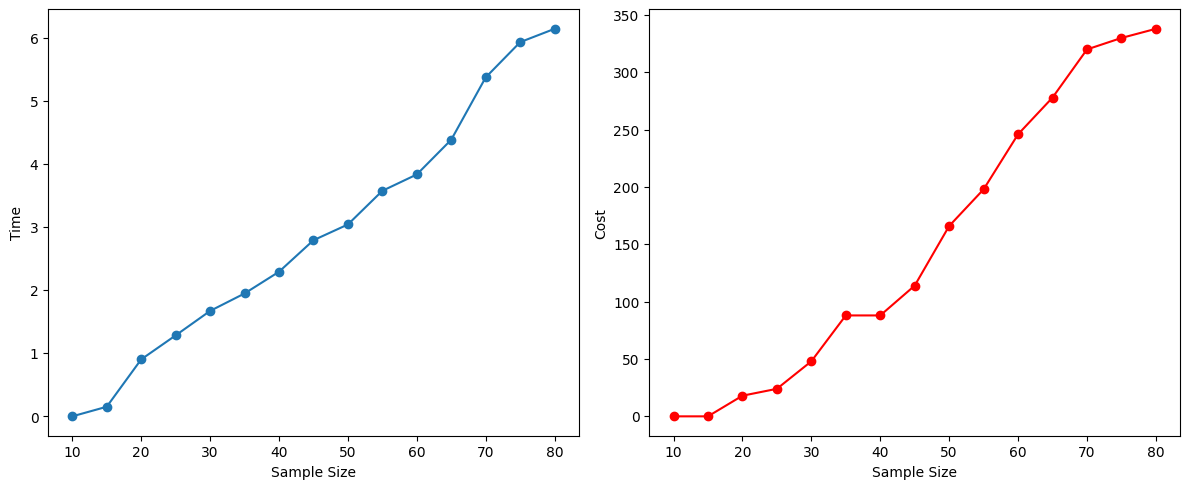

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(values, times, marker='o')
ax1.set_xlabel("Sample Size")
ax1.set_ylabel("Time")

ax2.plot(values, costs, marker='o', color='red')
ax2.set_xlabel("Sample Size")
ax2.set_ylabel("Cost")
plt.tight_layout()

plt.show()

## Variación en la conectividad entre paises

In [54]:
times: list = []
costs: list = []
values: list = []
for run in range(20):
    value: float = 1 - 1 / math.log(3 + 2 ** run)
    values.append(value)
    configure(sample_size=20, connectivity_rate=value)
    adjacency: np.array = generate_adjacency_matrix()
    episodes, cost, winner, duration = optimize(adjacency)
    print_results(episodes=episodes, cost=cost, winner=winner, adjacency=adjacency, duration=duration)
    costs.append(cost)
    times.append(duration)

Episode:  1
------------------------------------------------------
Episodes: 1
Time: 0.0021131038665771484
Cost:: 0
Colors: [3 3 4 2 1 2 1 4 3 2 2 2 3 2 2 2 2 2 4 4]
Results:
[[0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0]
 [0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 

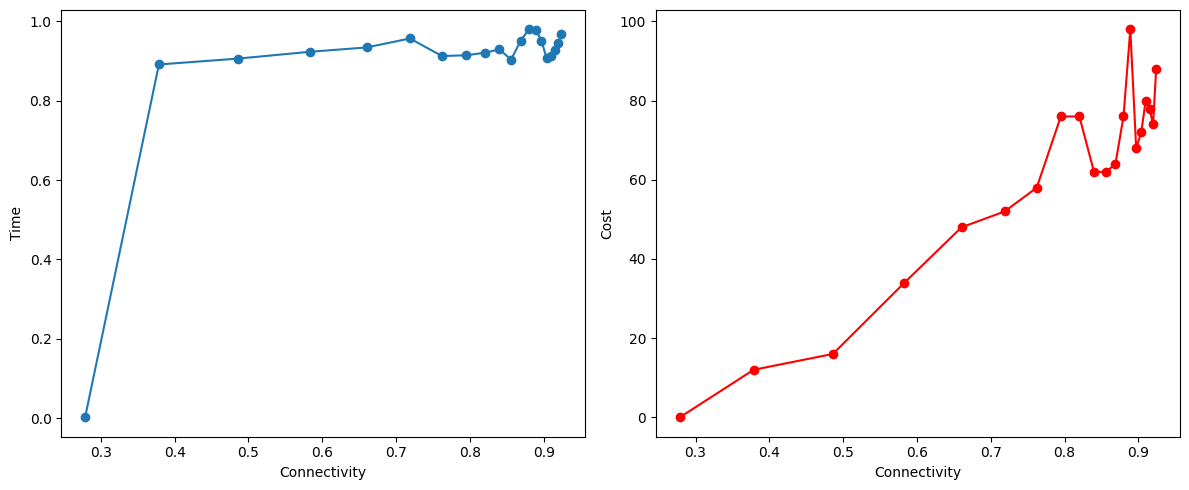

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(values, times, marker='o')
ax1.set_xlabel("Connectivity")
ax1.set_ylabel("Time")

ax2.plot(values, costs, marker='o', color='red')
ax2.set_xlabel("Connectivity")
ax2.set_ylabel("Cost")
plt.tight_layout()

plt.show()

## Variación en el tamaño de la población

In [65]:
times: list = []
costs: list = []
values: list = []
for run in range(20):
    value: int = 10 + 10 * run
    values.append(value)
    configure(sample_size=20, population_size=value)
    adjacency: np.array = generate_adjacency_matrix()
    episodes, cost, winner, duration = optimize(adjacency)
    print_results(episodes=episodes, cost=cost, winner=winner, adjacency=adjacency, duration=duration)
    costs.append(cost)
    times.append(duration)

Episode:  1
Episode:  2
Episode:  3
Episode:  4
Episode:  5
Episode:  6
Episode:  7
Episode:  8
Episode:  9
Episode:  10
Episode:  11
Episode:  12
Episode:  13
Episode:  14
Episode:  15
Episode:  16
Episode:  17
Episode:  18
Episode:  19
Episode:  20
Episode:  21
Episode:  22
Episode:  23
Episode:  24
Episode:  25
Episode:  26
Episode:  27
Episode:  28
Episode:  29
Episode:  30
Episode:  31
Episode:  32
Episode:  33
Episode:  34
Episode:  35
Episode:  36
Episode:  37
Episode:  38
Episode:  39
Episode:  40
Episode:  41
Episode:  42
Episode:  43
Episode:  44
Episode:  45
Episode:  46
Episode:  47
Episode:  48
Episode:  49
Episode:  50
Episode:  51
Episode:  52
Episode:  53
Episode:  54
Episode:  55
Episode:  56
Episode:  57
Episode:  58
Episode:  59
Episode:  60
Episode:  61
Episode:  62
Episode:  63
Episode:  64
Episode:  65
Episode:  66
Episode:  67
Episode:  68
Episode:  69
Episode:  70
Episode:  71
Episode:  72
Episode:  73
Episode:  74
Episode:  75
Episode:  76
Episode:  77
Episode:

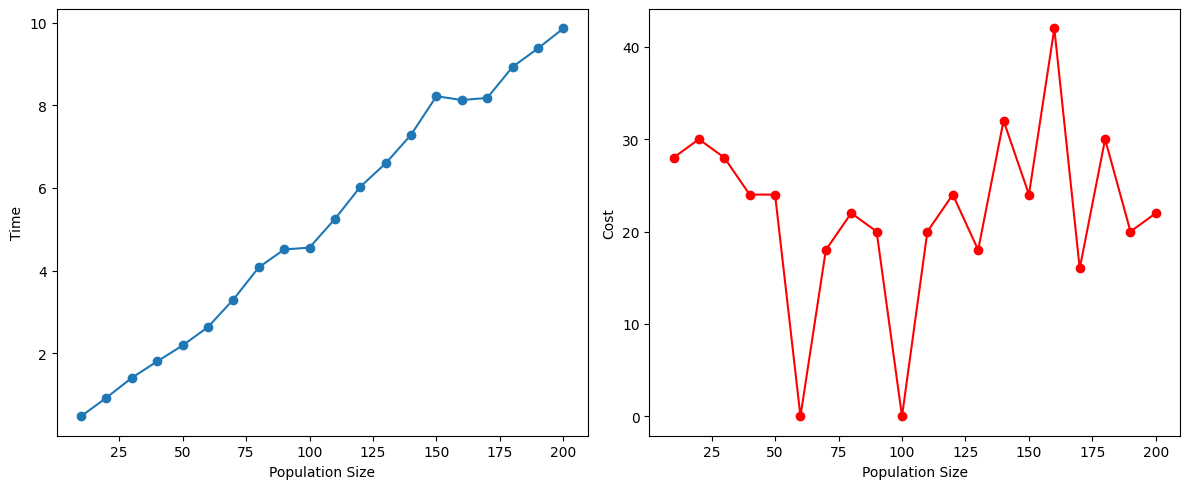

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(values, times, marker='o')
ax1.set_xlabel("Population Size")
ax1.set_ylabel("Time")

ax2.plot(values, costs, marker='o', color='red')
ax2.set_xlabel("Population Size")
ax2.set_ylabel("Cost")
plt.tight_layout()

plt.show()